# Predicting Employee Turnover

## HR Analytics
***

## Table of Contents

### The Problem
- [Why is Employee Turnover a Problem?](#problem)

### Pre-Processing
- [Pre-Processing: Categorical and Numerical Variable](#pre_processing)

### Class Imbalance
- [How to Treat Class Imbalance Problems](#class_imbalance)

### Split Train/Test Set
- [Splitting the Data into Train/Test Sets](#train_test_split)

### Resample Techniques to Treat Imbalance Data
- [Evaluate Original, Upsampled, and Downsampled Data Metrics](#resample)
- [Choose Which Sampling Technique to Use For Model - Upsampling](#upsampling)

### Train/Test Model Perfomance with 5-Fold CV
- [Logistic Regression Classifier](#lr)
- [Random Forest Classifier](#rf)
- [Support Vector Classifier](#svc)

### Evaluation Metric (F1 Score & ROC/AUC)
- [ROC and AUC](#roc)
- [Feature Importance](#feature_importance)

### Conclusion
- [Retention Plan](#retention_plan)

***
### Objective: 
- To understand what factors contributed most to employee turnover.

- To perform clustering to find any meaningful patterns of employee traits.

- To create a model that predicts the likelihood if a certain employee will leave the company or not. 

- To create or improve different retention strategies on targeted employees. 

The implementation of this model will allow management to create better decision-making actions.


<a id='problem'></a>
### The Problem:

One of the most common problems at work is **turnover.** 

Replacing a worker earning about **50,000 dollars** cost the company about **10,000 dollars** or 20% of that worker’s yearly income according to the Center of American Progress.

Replacing a high-level employee can cost multiple of that...

**Cost include:**
- Cost of off-boarding 
- Cost of hiring (advertising, interviewing, hiring)
- Cost of onboarding a new person (training, management time)
- Lost productivity (a new person may take 1-2 years to reach the productivity of an existing person)

**Annual Cost of Turnover** = (Hiring + Onboarding + Development + Unfilled Time) * (# Employees x Annual Turnover Percentage)

**Annual Cost of Turnover** = (1,000 + 500) x (15,000 * 24%)

**Annual Cost of Turnover)** = 1500 x 3600

**Annual Cost of Turnover)** = 5400000


## Example

1. Jobs (earning under 30k a year): the cost to replace a 10/hour retail employee would be **3,328 dollars**.
2. Jobs (earning 30k-50k a year) - the cost to replace a 40k manager would be **8,000 dollars**.
3. Jobs of executives (earning 100k+ a year) - the cost to replace a 100k CEO is **213,000 dollars**.

In [1]:
__author__ = "Prasanth Damodharan"
__email__ = "prasanthdamo@gmail.com"

In [1]:
# Import the neccessary modules for data manipulation and visual representation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
%matplotlib inline

In [10]:
pip install --user imblearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv('HR-data.csv')

In [3]:
# Rename Columns
# Renaming certain columns for better readability
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_project': 'projectCount',
                        'average_montly_hours': 'averageMonthlyHours',
                        'time_spend_company': 'yearsAtCompany',
                        'Work_accident': 'workAccident',
                        'promotion_last_5years': 'promotion',
                        'sales' : 'department',
                        'left' : 'turnover'
                        })

df.head(3)

,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,turnover,promotion,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


<a id='pre_processing'></a>
# Pre-processing 
***

- Apply **get_dummies()** to the categorical variables.
- Seperate categorical variables and numeric variables, then combine them.

In [4]:
cat_var = ['department','salary','turnover','promotion']
num_var = ['satisfaction','evaluation','projectCount','averageMonthlyHours','yearsAtCompany', 'workAccident']
categorical_df = pd.get_dummies(df[cat_var], drop_first=True)
numerical_df = df[num_var]
new_df = pd.concat([categorical_df,numerical_df], axis=1)
new_df.head()

,turnover,promotion,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.38,0.53,2,157,3,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0.80,0.86,5,262,6,0
2,1,0,0,0,0,0,0,0,1,0,0,0,1,0.11,0.88,7,272,4,0
3,1,0,0,0,0,0,0,0,1,0,0,1,0,0.72,0.87,5,223,5,0
4,1,0,0,0,0,0,0,0,1,0,0,1,0,0.37,0.52,2,159,3,0


<a id='class_imbalance'></a>
# Class Imbalance

### Employee Turnover Rate: 24%

In [5]:
df.turnover.value_counts(1)

0    0.761917
1    0.238083
Name: turnover, dtype: float64

Text(0, 0.5, 'Count')

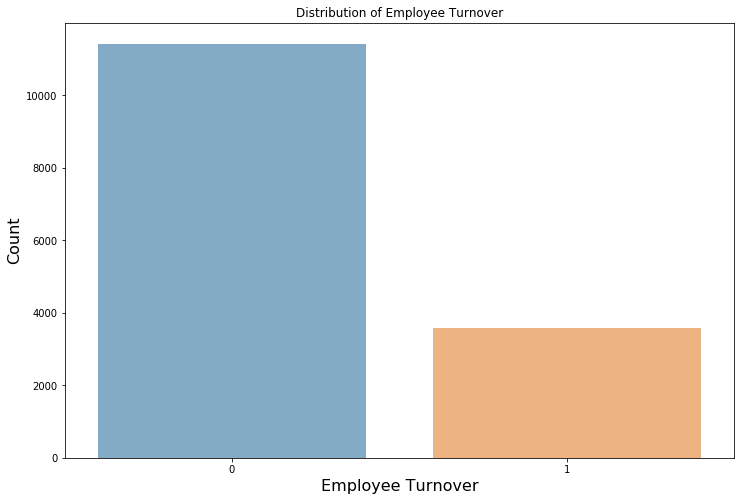

In [6]:
plt.figure(figsize=(12,8))
turnover = df.turnover.value_counts()
sns.barplot(y=turnover.values, x=turnover.index, alpha=0.6)
plt.title('Distribution of Employee Turnover')
plt.xlabel('Employee Turnover', fontsize=16)
plt.ylabel('Count', fontsize=16)

# How to Treat Imbalanced Datasets

There are many ways of dealing with imbalanced data. We will focus in the following approaches:

1. Oversampling — SMOTE
2. Undersampling — RandomUnderSampler

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve

# Create the X and y set
X = new_df.iloc[:,1:]
y = new_df.iloc[:,0]

# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

<a id='resample'></a>
# Resample Methods

Let's train a base logistic regression model on the three types of samples to see which yields the best result:
1. **Orginal Sample**
2. **Upsampling Data**
3. **Downsampling Data**

In [12]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE 

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)

X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))


# Upsample using SMOTE
sm = SMOTE(random_state=12)
x_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)


# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))


print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print ("SMOTE sample shape:", x_train_sm.shape, y_train_sm.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 18) (11999,)
Upsampled shape: (18284, 18) (18284,)
SMOTE sample shape: (18284, 18) (18284,)
Downsampled shape: (5714, 18) (5714,)


<a id='upsampling'></a>
# Choose Which Sampling Technique to Use For Model
***

### Apply 10-Fold Cross Validation for Logistic Regression
#### Train on Original, Upsampled, SMOTE, and Downsampled Data

**Objective**:Train our Logistic Regression Model to our **original, upsampled, and downsampled data** to see which performs best. 

**Resut:**
- **Original Sample**: F1 Score 44.96%
- **Upsample:** F1 Score 77.93%
- **SMOTE:** F1 Score 78.8%
- **Downsample:** F1 Score 77.85%

**SMOTE gives us the best performance**

## Upsample
You randomly resample the minority class to create new data. 

## SMOTE
You use the nearest neighbors of the minority observations to create new synthetic data

## Downsample
You remove some samples of the majority class

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "SMOTE":(x_train_sm, y_train_sm),
                "Downsampled": (X_train_d, y_train_d)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='f1')
    print(f"The best F1 Score for {method} data:")
    print (lr_results.mean())
 
cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring='f1').mean()

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

The best F1 Score for Original data:
0.5015326373710105


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

The best F1 Score for Upsampled data:
0.7642858243398731


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

The best F1 Score for SMOTE data:
0.7850974449621695


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

The best F1 Score for Downsampled data:
0.7732906304576032


D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_ms

0.5976311389234822

# Train Three Models
***

1. Logistic Regression
2. Random Forest
3. Support Vector Machine

<a id='lr'></a>
# Test Logistic Regression Performance
### Logistic Regression F1 Score (0.78)

In [17]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

lr = LogisticRegression()

# Fit the model to the Upsampling data
lr = lr.fit(x_train_sm, y_train_sm)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(x_train_sm, y_train_sm)
print(classification_report(y_test, lr.predict(X_test)))

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)




 ---Logistic Regression Model---
Logistic Regression AUC = 0.76
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2286
           1       0.50      0.77      0.61       714

    accuracy                           0.76      3000
   macro avg       0.71      0.76      0.72      3000
weighted avg       0.81      0.76      0.78      3000



D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<a id='rf'></a>
# Random Forest Classifier 
***

Notice how the random forest classifier takes a while to run on the dataset. That is one downside to the algorithm, it takes a lot of computation. But it has a better performance than the sipler models like Logistic Regression

### Apply 5-Fold Cross Validation for Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
rf = RandomForestClassifier()

rf_result = cross_val_score(rf, x_train_sm, y_train_sm, cv=5, scoring='f1')

rf_result.mean()

0.9803737697265129

### Random Forest F1 Score (0.99)

In [21]:
from sklearn.metrics import roc_auc_score

rf = rf.fit(x_train_sm, y_train_sm)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



<a id='svc'></a>
# Gradient Boosting Classifier


In [23]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gbc = GradientBoostingClassifier()  

gbc = gbc.fit(x_train_sm,y_train_sm)

gbc

GradientBoostingClassifier()

### Apply 5-Fold Cross Validation for Gradient Boosting Classifier

In [25]:
gbc_result = cross_val_score(gbc, x_train_sm, y_train_sm, cv=5, scoring='f1')
gbc_result.mean()

0.9576953089675155

### Gradient Boosting Classifier F1 Score (0.94)

In [27]:
from sklearn.metrics import roc_auc_score

print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test, gbc.predict(X_test))
print ("Gradient Boosting Classifier AUC = %2.2f" % gbc_auc)
print(classification_report(y_test, gbc.predict(X_test)))



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.96
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.92      0.94      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



<a id='roc'></a>
# ROC Graph

In [28]:
rf.predict_proba(X_test)

array([[1.  , 0.  ],
       [0.15, 0.85],
       [0.89, 0.11],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.01, 0.99]])

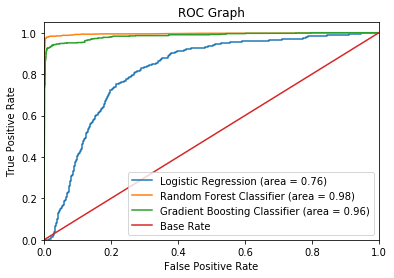

In [29]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_fpr, gbc_tpr, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)

# Plot Decision Tree ROC
plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Classifier (area = %0.2f)' % gbc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Confusion Matrix for Linear Regresion
confusion_matrix(y_test, lr.predict(X_test))

array([[1739,  547],
       [ 167,  547]], dtype=int64)

In [31]:
confusion_matrix(y_test, gbc.predict(X_test))

array([[2227,   59],
       [  43,  671]], dtype=int64)

In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf.predict(X_test))

array([[2262,   24],
       [  15,  699]], dtype=int64)

# Recall or Precision?
***
It depends on how much cost/weight you want on your two types of errors: (1) **False Positives** or (2) **False Negatives**

What's the coset of having a FN and FP?


**Optimize Recall When:**
- You want to limit **false negatives**
- You will get more False Positives
- FN > FP
- Example: Predicting Cancer Patients or Credit Card Fraud

**Optimize Precision When:**
- You want to limit **false positives**
- FP > FN
- Example: Spam VS Not Spam

<a id='feature_importance'></a>
# Random Forest Feature Importances

In [35]:
# Get Feature Importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,satisfaction,0.275565
1,yearsAtCompany,0.231113
2,averageMonthlyHours,0.150943
3,projectCount,0.146508
4,evaluation,0.136136
5,workAccident,0.023333
6,salary_low,0.007453
7,salary_medium,0.004630
8,department_sales,0.004598
9,department_technical,0.003976


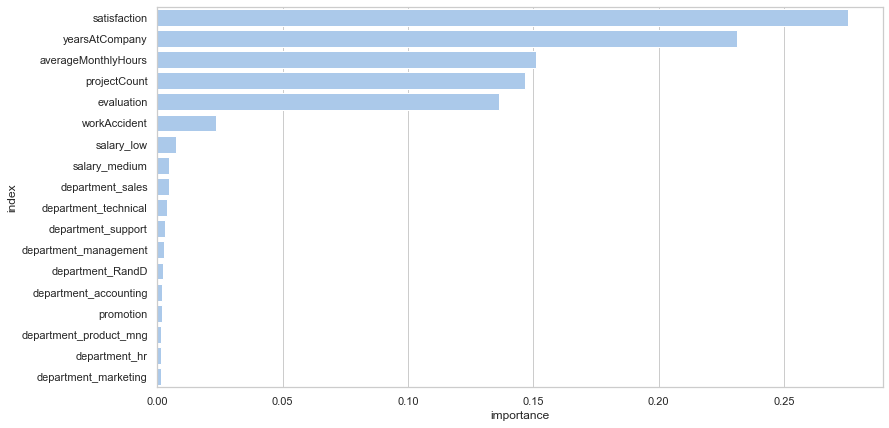

In [36]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

# Apply Random Noise to Feature Importance

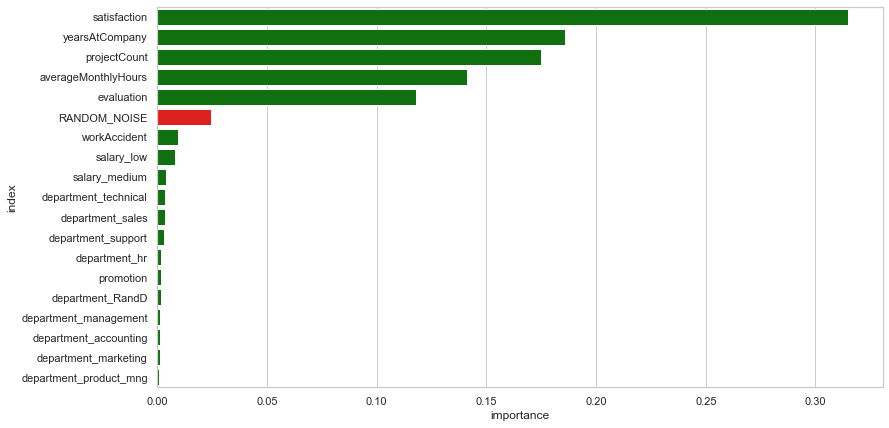

In [37]:
# Apply Random Noise to data set
X_train_rnoise = pd.DataFrame(X_train)
X_train_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet
rf_random = RandomForestClassifier()
rf_random = rf_random.fit(X_train_rnoise, y_train)

# Get Feature Importances
feature_importances_random = pd.DataFrame(rf_random.feature_importances_, index = X_train_rnoise.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))


clrs = ['red' if (x == 5 ) else 'green' for x in feature_importances_random.index.values ]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random,
            label="Total",  palette=clrs)

In [38]:
X_train_rnoise.head()

,promotion,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,satisfaction,evaluation,projectCount,averageMonthlyHours,yearsAtCompany,workAccident,RANDOM_NOISE
6197,0,0,0,0,0,0,0,1,0,0,1,0,0.15,0.39,5,229,4,0,1.198238
1955,0,0,0,0,0,0,0,0,1,0,1,0,0.09,0.81,6,257,4,0,1.853369
9440,0,0,0,0,0,0,0,0,1,0,1,0,0.57,0.49,2,237,2,0,0.098109
9365,0,0,0,0,0,0,0,0,1,0,1,0,0.85,0.59,2,264,2,0,0.970903
7725,0,0,0,0,0,0,0,1,0,0,0,0,0.16,0.72,4,192,6,0,0.135141


**Reference:** http://rupeshkhare.com/wp-content/uploads/2013/12/Employee-Attrition-Risk-Assessment-using-Logistic-Regression-Analysis.pdf

Since this model is being used for people, we should refrain from soley relying on the output of our model. Instead, we can use it's probability output and design our own system to treat each employee accordingly. 

1.	**Safe Zone (Green)** – Employees within this zone are considered safe. 
2.	**Low Risk Zone (Yellow)** – Employees within this zone are too be taken into consideration of potential turnover. This is more of a long-term track.
3.	**Medium Risk Zone (Orange)** – Employees within this zone are at risk of turnover. Action should be taken and monitored accordingly. 
4.	**High Risk Zone (Red)** – Employees within this zone are considered to have the highest chance of turnover. Action should be taken immediately. 



In [1]:
rf.predict_proba(X_test)[175:225]

NameError: name 'rf' is not defined

## Conclusion
**Binary Classification**: Turnover V.S. Non Turnover

**Instance Scoring**: Likelihood of employee responding to an offer/incentive to save them from leaving.

**Need for Action**: Save employees from leaving

In our employee retention problem, rather than simply predicting whether an employee will leave the company within a certain time frame, we would much rather have an estimate of the probability that he/she will leave the company. 
We would rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances. 

Consider employee turnover domain where an employee is given treatment by Human  Resources because they think the employee will leave the company within a month, but the employee actually does not. This is a false positive. This mistake could be expensive, inconvenient, and time consuming for both the Human Resources and employee, but is a good investment for relational growth. 

Compare this with the opposite error, where Human Resources does not give treatment/incentives to the employees and they do leave. This is a false negative. This type of error is more detrimental because the company lost an employee, which could lead to great setbacks and more money to rehire. 
Depending on these errors, different costs are weighed based on the type of employee being treated. For example, if it’s a high-salary employee then would we need a costlier form of treatment? What if it’s a low-salary employee? The cost for each error is different and should be weighed accordingly. 
 
 **Solution 1:** 
 - We can rank employees by their probability of leaving, then allocate a limited incentive budget to the highest probability instances.
 - OR, we can allocate our incentive budget to the instances with the highest expected loss, for which we'll need the probability of turnover.

**Solution 2:** 
Develop learning programs for managers. Then use analytics to gauge their performance and measure progress. Some advice:
 - Be a good coach
 - Empower the team and do not micromanage
 - Express interest for team member success
 - Have clear vision / strategy for team
 - Help team with career development    

## Selection Bias
***

- One thing to note about this dataset is the turnover feature. We don't know if the employees that left are interns, contractors, full-time, or part-time. These are important variables to take into consideration when performing a machine learning algorithm to it. 

- Another thing to note down is the type of bias of the evaluation feature. Evaluation is heavily subjective, and can vary tremendously depending on who is the evaluator. If the employee knows the evaluator, then he/she will probably have a higher score. 